In [1]:
import os
os.chdir("../../")

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import scanpy as sc
import scnet as sn
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsTransformer, DistanceMetric

Using TensorFlow backend.


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [5]:
sc.settings.set_figure_params(dpi=100)
sc.settings.figdir = "./results/integration/HCL_MCA/"

In [6]:
base_path = "/media/pgdrive/sharif/exosomians/mohsen/data/hcl/"
condition_key = "species_age"
cell_type_key = 'celltype'
target_conditions = ["Mouse - Adult", 'Mouse - Fetal', 'Mouse - Neonatal', 'Mouse - Embryonic']

# Loading Tabula Senis datasets and data preparation

In [7]:
adata = sc.read(os.path.join(base_path, "hcl_mca_5k_species_age.h5ad"))
adata

AnnData object with n_obs × n_vars = 420687 × 5000 
    obs: 'batch', 'cellnames', 'celltype', 'cluster', 'donor', 'sample', 'stage', 'tissue', 'species', 'species_tissue', 'tissue_refined', 'age', 'species_age', 'species_stage'
    var: 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [8]:
source_adata = adata[~adata.obs[condition_key].isin(target_conditions)]
source_adata

View of AnnData object with n_obs × n_vars = 277909 × 5000 
    obs: 'batch', 'cellnames', 'celltype', 'cluster', 'donor', 'sample', 'stage', 'tissue', 'species', 'species_tissue', 'tissue_refined', 'age', 'species_age', 'species_stage'
    var: 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [9]:
target_adata = adata[adata.obs[condition_key].isin(target_conditions)]
target_adata

View of AnnData object with n_obs × n_vars = 142778 × 5000 
    obs: 'batch', 'cellnames', 'celltype', 'cluster', 'donor', 'sample', 'stage', 'tissue', 'species', 'species_tissue', 'tissue_refined', 'age', 'species_age', 'species_stage'
    var: 'n_cells-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [10]:
source_adata.obs['species_stage'].value_counts()

Human - Adult    172363
Human - Fetus    105546
Name: species_stage, dtype: int64

In [11]:
target_adata.obs['species_stage'].value_counts()

Mouse - Adult       70625
Mouse - Fetal       46917
Mouse - Neonatal    25236
Name: species_stage, dtype: int64

## Train/Test Split

In [12]:
train_adata, valid_adata = sn.utils.train_test_split(source_adata, 0.80)

In [13]:
train_adata.shape, valid_adata.shape

((222327, 5000), (55582, 5000))

In [14]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_conditions

3

# Create & Train model with training data

In [15]:
network = sn.archs.scNet(x_dimension=train_adata.shape[1], 
                         z_dimension=30,
                         architecture=[128, 20],
                         n_conditions=n_conditions,
                         use_batchnorm=False,
                         lr=0.001,
                         alpha=0.0001,
                         beta=40,
                         eta=1000,
                         clip_value=10,
                         loss_fn='mse',
                         mmd_computation_method='general',
                         model_path="./models/CVAE/hcl_mca_species_stage/before/",
                         dropout_rate=0.05,
                         output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## We assign each study to a numerical label 

In [16]:
train_adata.obs[condition_key].value_counts()

Human - Adult       137842
Human - Fetal        82178
Human - Neonatal      2307
Name: species_age, dtype: int64

In [17]:
conditions = source_adata.obs[condition_key].unique().tolist()
condition_encoder = sn.utils.create_dictionary(sorted(conditions), target_conditions)
condition_encoder

{'Human - Adult': 0, 'Human - Fetal': 1, 'Human - Neonatal': 2}

## Training the network

In [18]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=1000,
              n_per_epoch=0,
              batch_size=512, 
              early_stop_limit=30,
              lr_reducer=20, 
              save=True, 
              retrain=False,
              verbose=5)

Instructions for updating:
Use tf.cast instead.
 |█████████-----------| 45.9%  - loss: 104.0262 - reconstruction_loss: 99.2762 - mmd_loss: 4.7501 - val_loss: 101.4858 - val_reconstruction_loss: 97.0365 - val_mmd_loss: 4.44931

In [30]:
network.condition_encoder

{'Human - Adult': 0, 'Human - Fetal': 1, 'Human - Neonatal': 2}

In [20]:
plot_adata = sc.pp.subsample(source_adata, n_obs=200000, copy=True)

In [21]:
encoder_labels, _ = sn.utils.label_encoder(
    plot_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [22]:
latent_adata = network.to_mmd_layer(plot_adata, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 200000 × 20 
    obs: 'batch', 'cellnames', 'celltype', 'cluster', 'donor', 'sample', 'stage', 'tissue', 'species', 'species_tissue', 'tissue_refined', 'age', 'species_age', 'species_stage'

In [23]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [24]:
latent_adata.write_h5ad(os.path.join(base_path, "latents/species_age/pretrain.h5ad"))

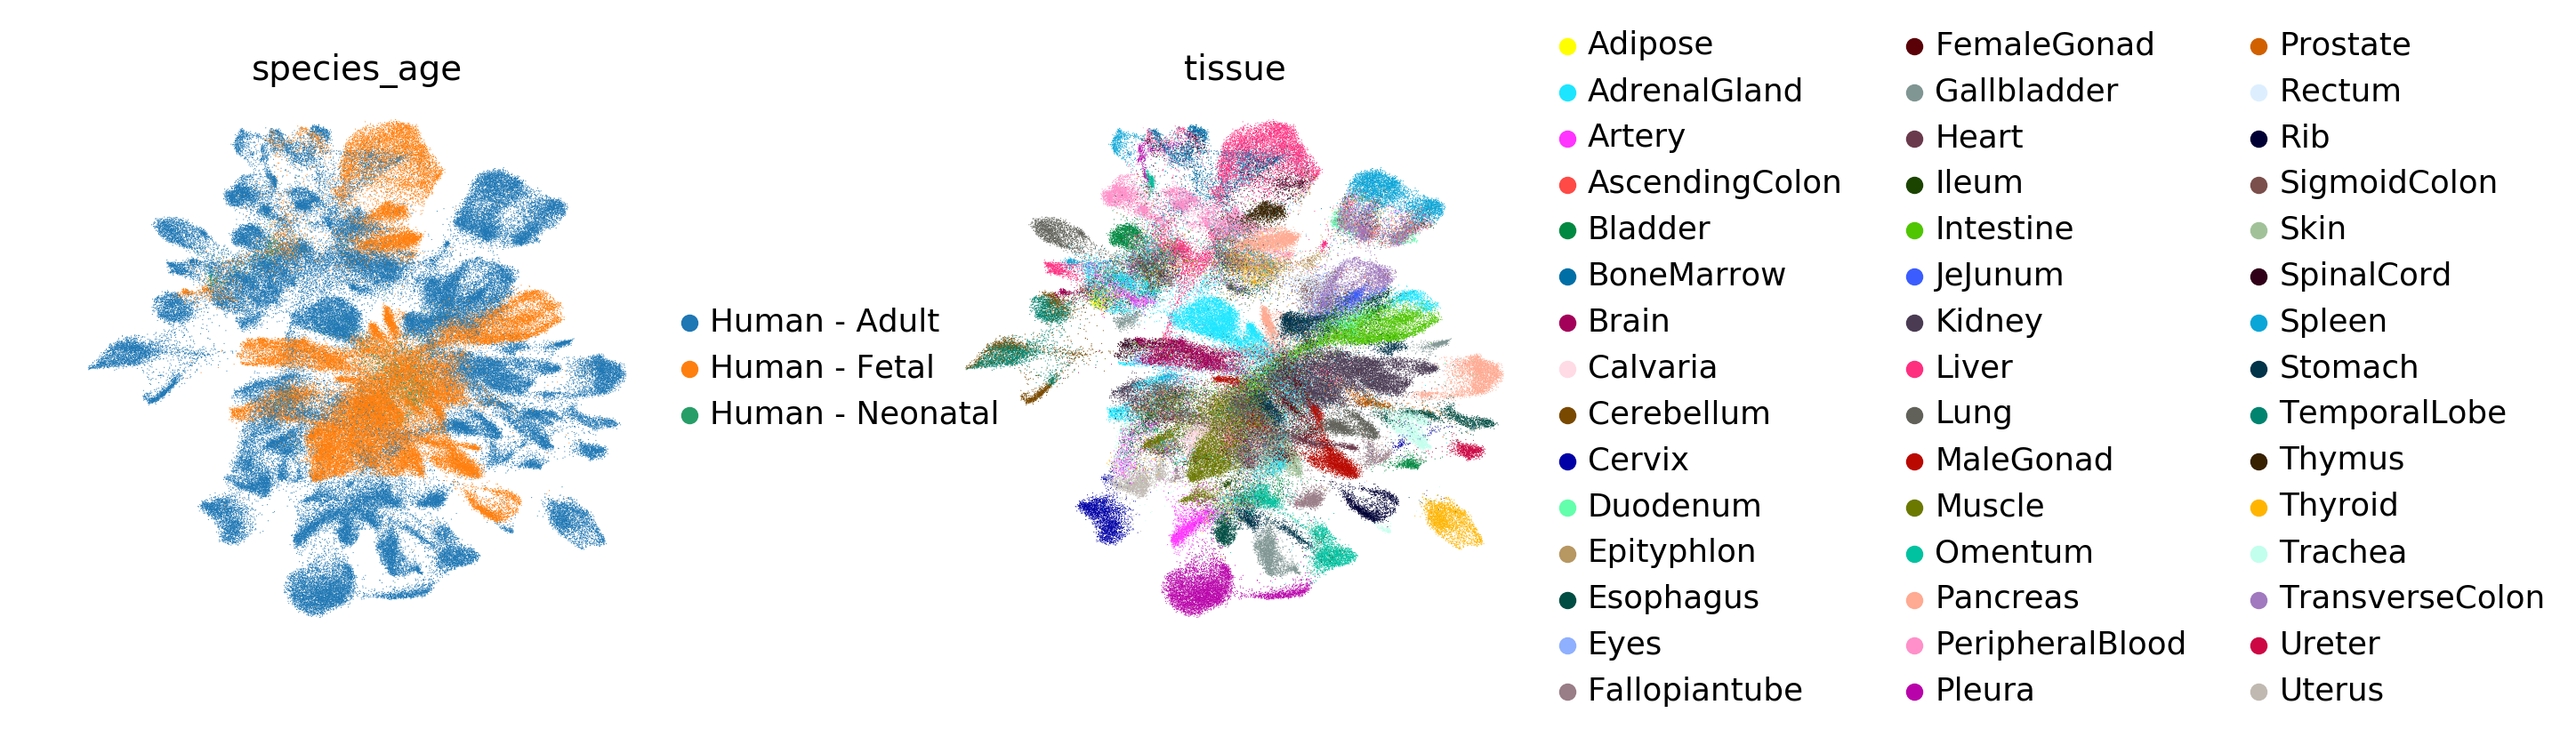

In [25]:
sc.pl.umap(latent_adata, color=['species_age', 'tissue'], wspace=0.35, frameon=False)

In [26]:
special_cell_types = ['Epithelial', 'Stromal', 'Erythroid', 
                      'Muscle', 'Immune', 'Endothelial',
                      'Germline', 'Hepatocyte']

In [27]:
def celltype_processor(cell_type):
    for special_cell_type in special_cell_types:
        if cell_type.startswith(special_cell_type):
            return special_cell_type
    return 'others'

In [28]:
latent_adata.obs['spec_celltype'] = latent_adata.obs['celltype'].apply(lambda x: celltype_processor(x))

In [29]:
special_latent = latent_adata[latent_adata.obs['spec_celltype'].isin(special_cell_types)]

Trying to set attribute `.obs` of view, copying.
... storing 'spec_celltype' as categorical


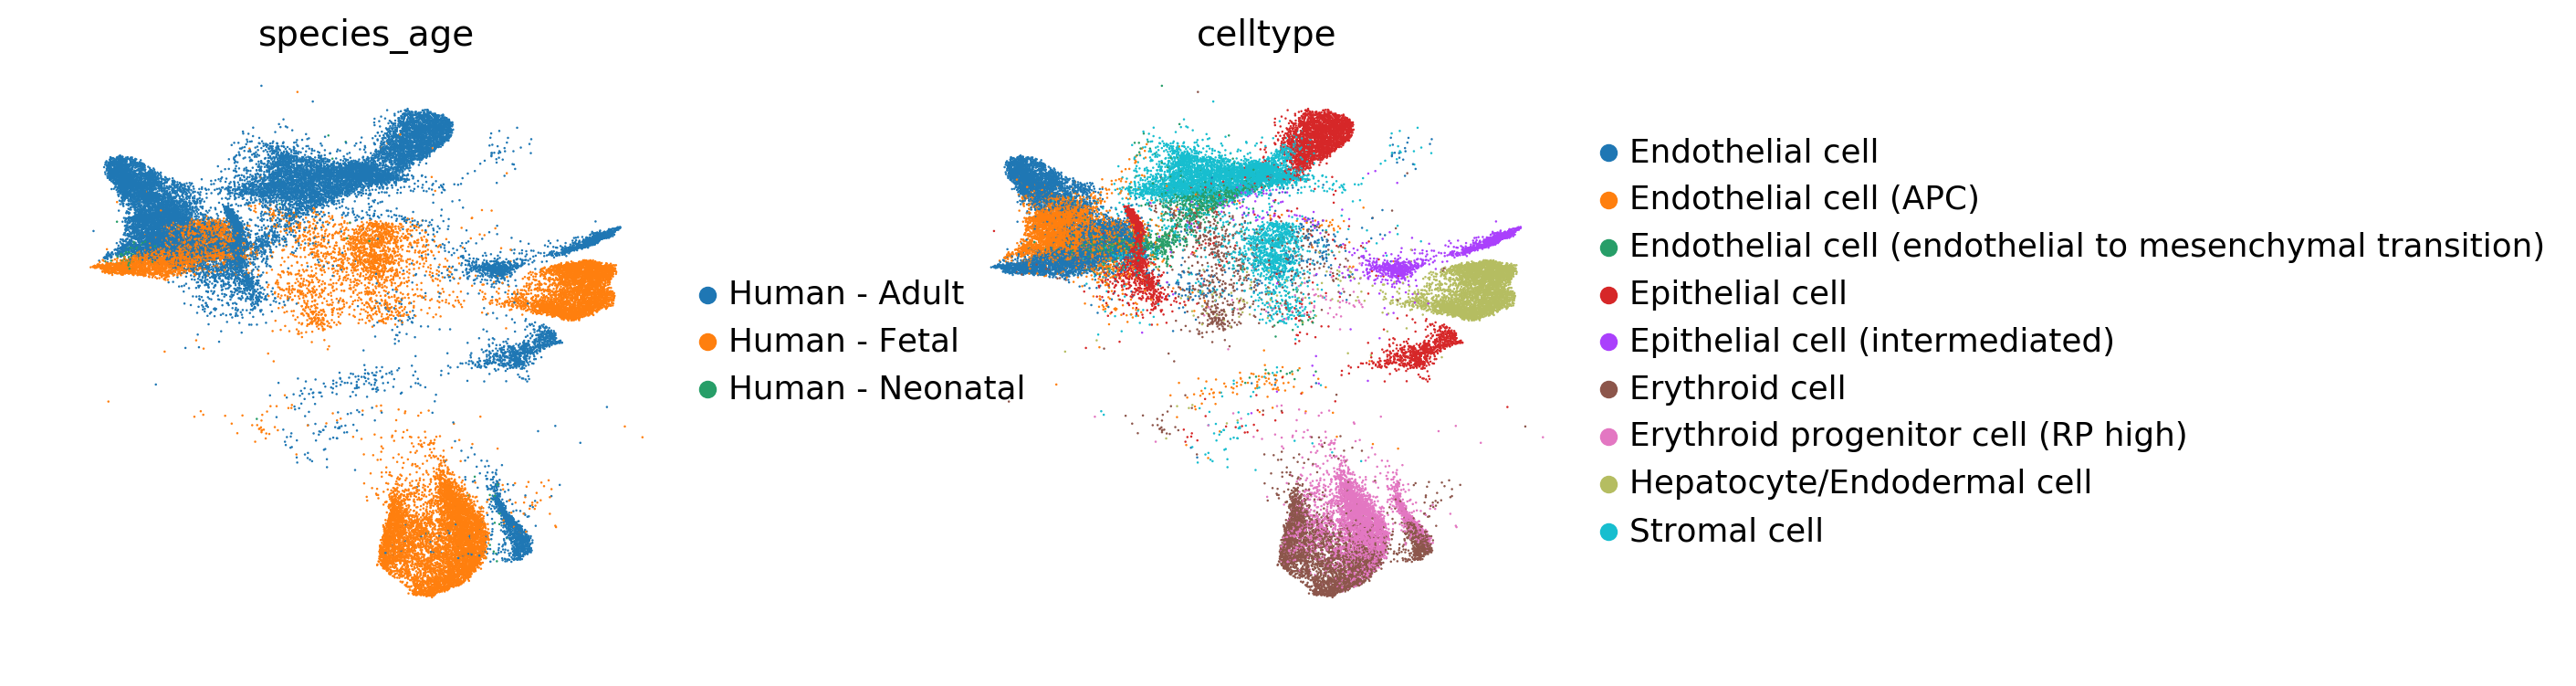

In [30]:
sc.pl.umap(special_latent, color=['species_age', 'celltype'], wspace=0.35, frameon=False)

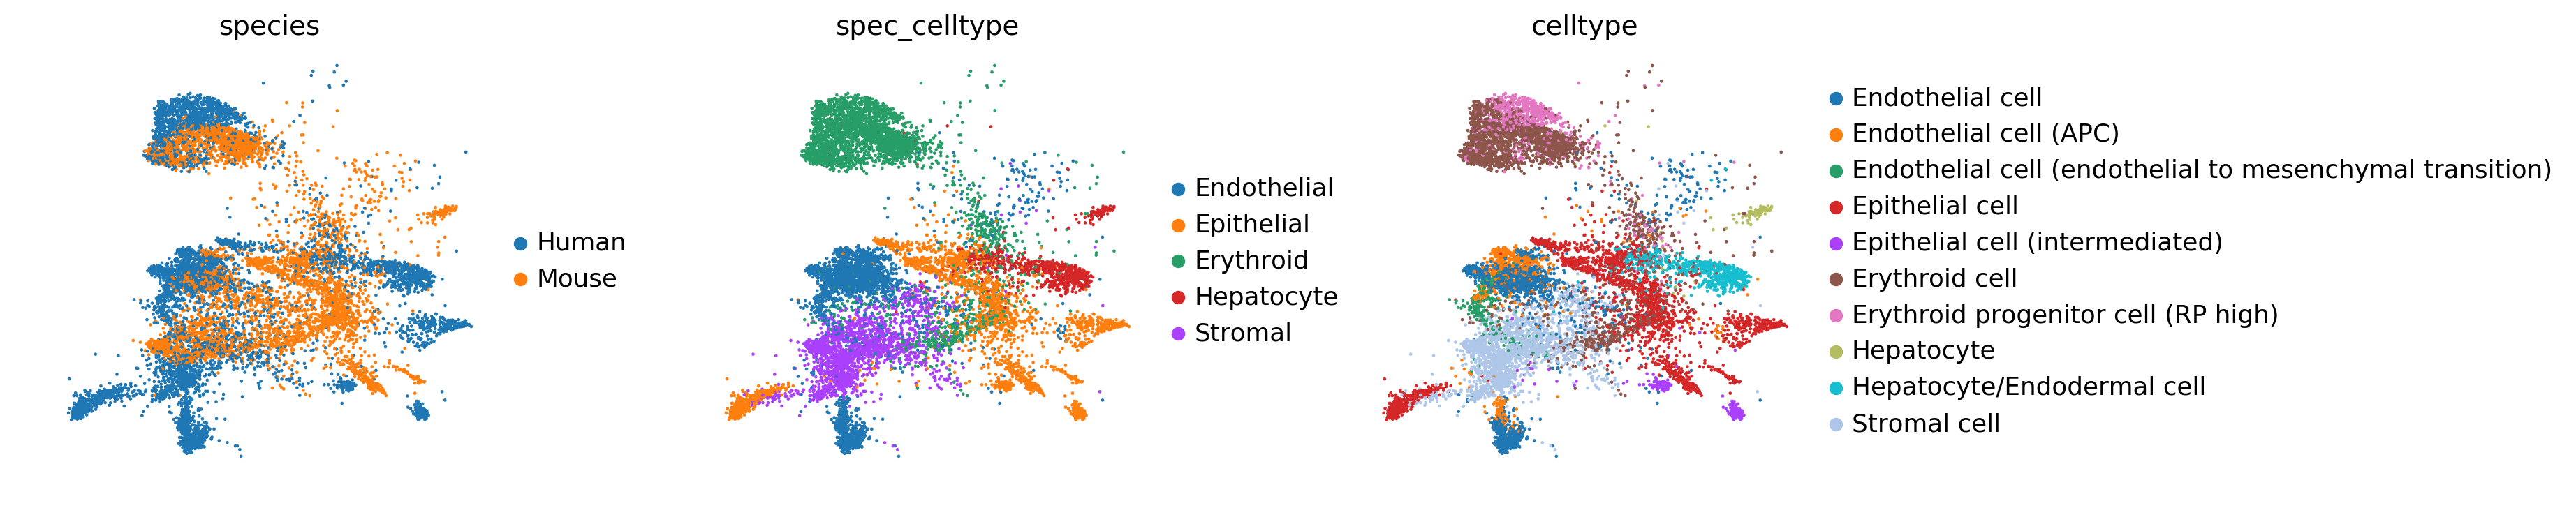

In [67]:
sc.pl.umap(special_latent, color=['species', 'spec_celltype', 'celltype'], wspace=0.35, frameon=False)

# Perfroming architecture Surgery

In [32]:
new_network = sn.operate(network, 
                          new_conditions=target_conditions,
                          init='Xavier', 
                          freeze=True,
                          freeze_expression_input=True,
                          remove_dropout=False,
                          new_training_kwargs={"beta": 50},
                         )

In [68]:
new_network.condition_encoder

{'Human - Adult': 0,
 'Human - Fetal': 1,
 'Human - Neonatal': 2,
 'Mouse - Adult': 3,
 'Mouse - Fetal': 4,
 'Mouse - Neonatal': 5,
 'Mouse - Embryonic': 6}

## Train with small new dataset containing out-of-sample condition

In [34]:
train_adata, valid_adata = sn.utils.train_test_split(target_adata, 0.80)

In [35]:
train_adata.shape, valid_adata.shape

((114222, 5000), (28556, 5000))

In [36]:
new_network.model_path = "./models/CVAE/hcl_mca_species_age/after/"

In [37]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=1000,
                  batch_size=512, 
                  early_stop_limit=30,
                  lr_reducer=20, 
                  n_per_epoch=0,
                  save=True,
                  retrain=True,
                  verbose=5)

 |███-----------------| 17.6%  - loss: 104.1359 - reconstruction_loss: 101.3919 - mmd_loss: 2.7440 - val_loss: 102.9836 - val_reconstruction_loss: 100.0875 - val_mmd_loss: 2.896126065

In [38]:
encoder_labels, _ = sn.utils.label_encoder(target_adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [39]:
latent_adata = new_network.to_mmd_layer(target_adata, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 142778 × 20 
    obs: 'batch', 'cellnames', 'celltype', 'cluster', 'donor', 'sample', 'stage', 'tissue', 'species', 'species_tissue', 'tissue_refined', 'age', 'species_age', 'species_stage'

In [40]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

In [40]:
latent_adata.write_h5ad(os.path.join(base_path, "latents/species_age/mca.h5ad"))

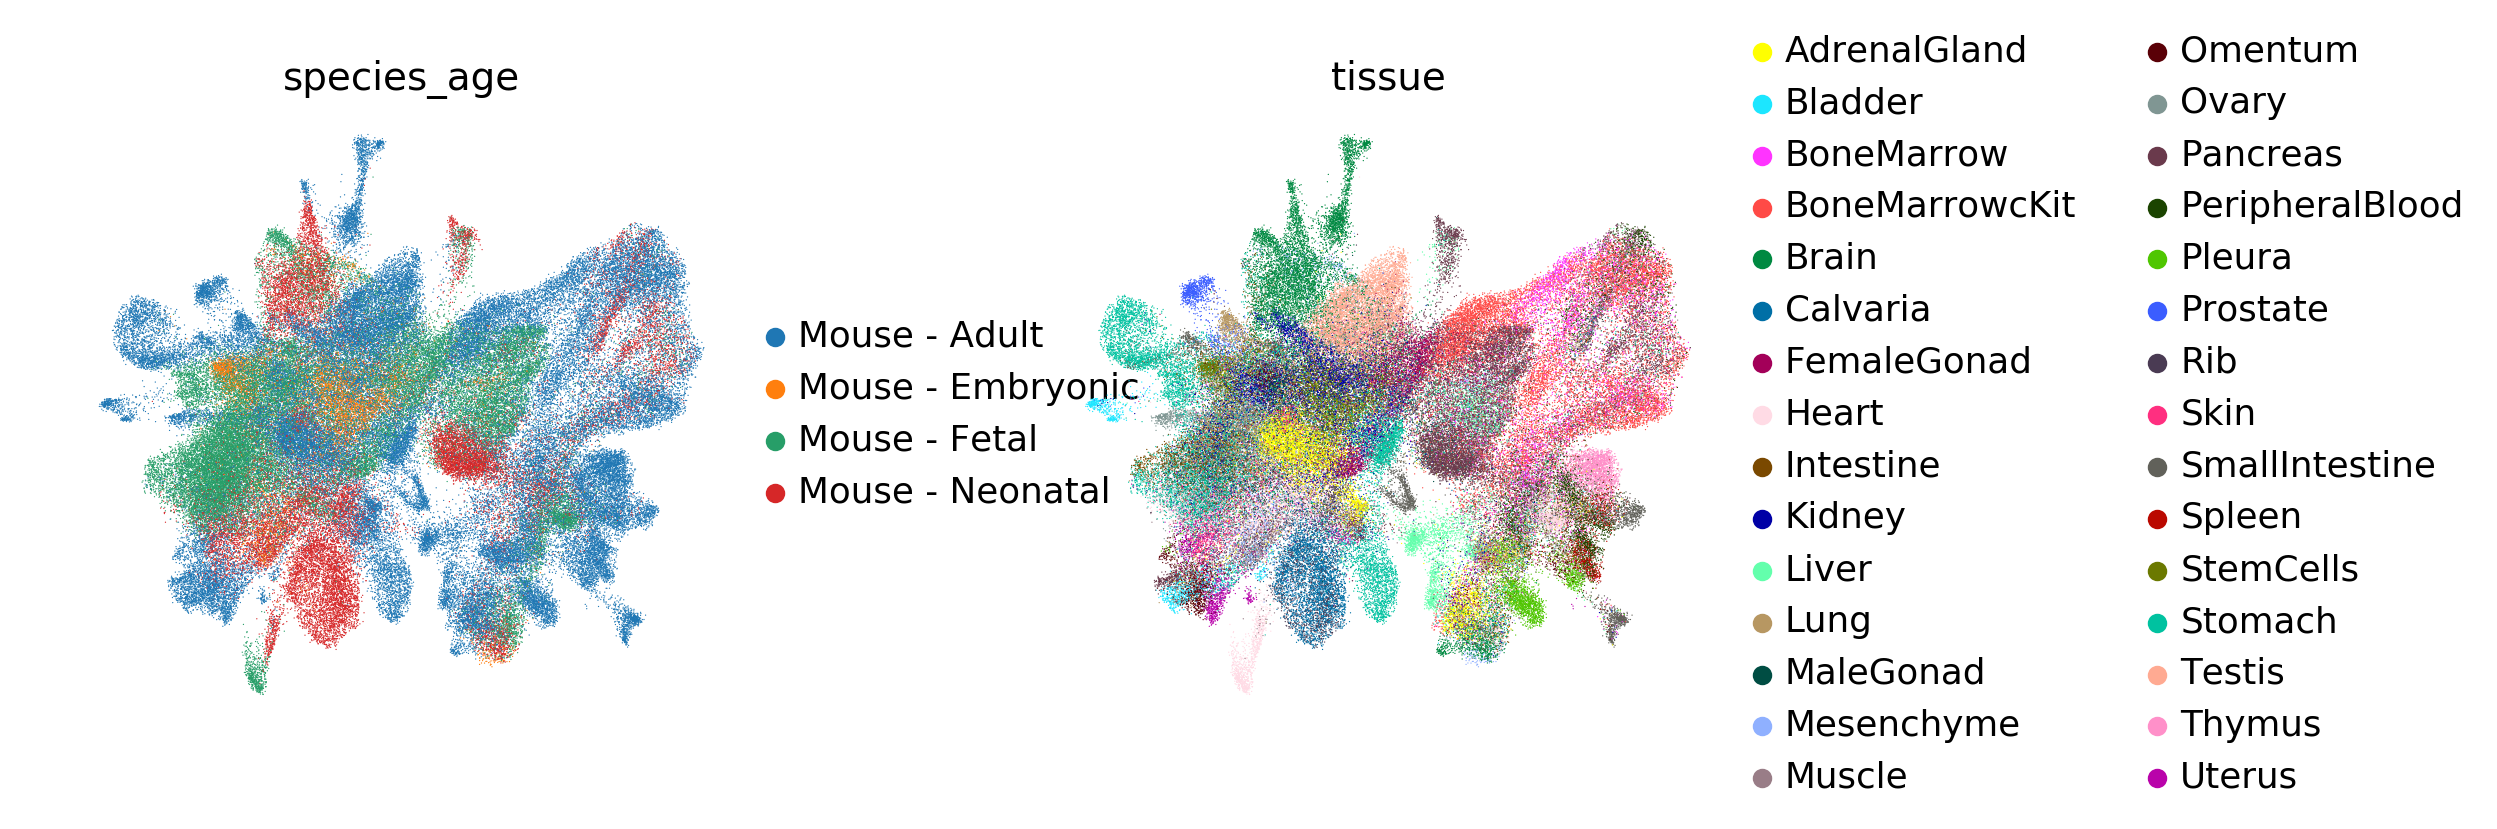

In [41]:
sc.pl.umap(latent_adata, color=['species_age', 'tissue'], wspace=0.35, frameon=False)

In [71]:
source_subsampled = sc.pp.subsample(source_adata, n_obs=160000, copy=True)

In [72]:
plot_adata = source_subsampled.concatenate(target_adata)

In [42]:
plot_adata = sc.pp.subsample(adata, n_obs=50000, copy=True)

In [73]:
encoder_labels, _ = sn.utils.label_encoder(plot_adata, 
                                           label_encoder=new_network.condition_encoder, 
                                           condition_key=condition_key)

In [74]:
latent_adata = new_network.to_mmd_layer(plot_adata, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 302778 × 20 
    obs: 'age', 'batch', 'cellnames', 'celltype', 'cluster', 'donor', 'sample', 'species', 'species_age', 'species_stage', 'species_tissue', 'stage', 'tissue', 'tissue_refined'

In [75]:
latent_adata.obs['species'].value_counts()

Human    160000
Mouse    142778
Name: species, dtype: int64

In [ ]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

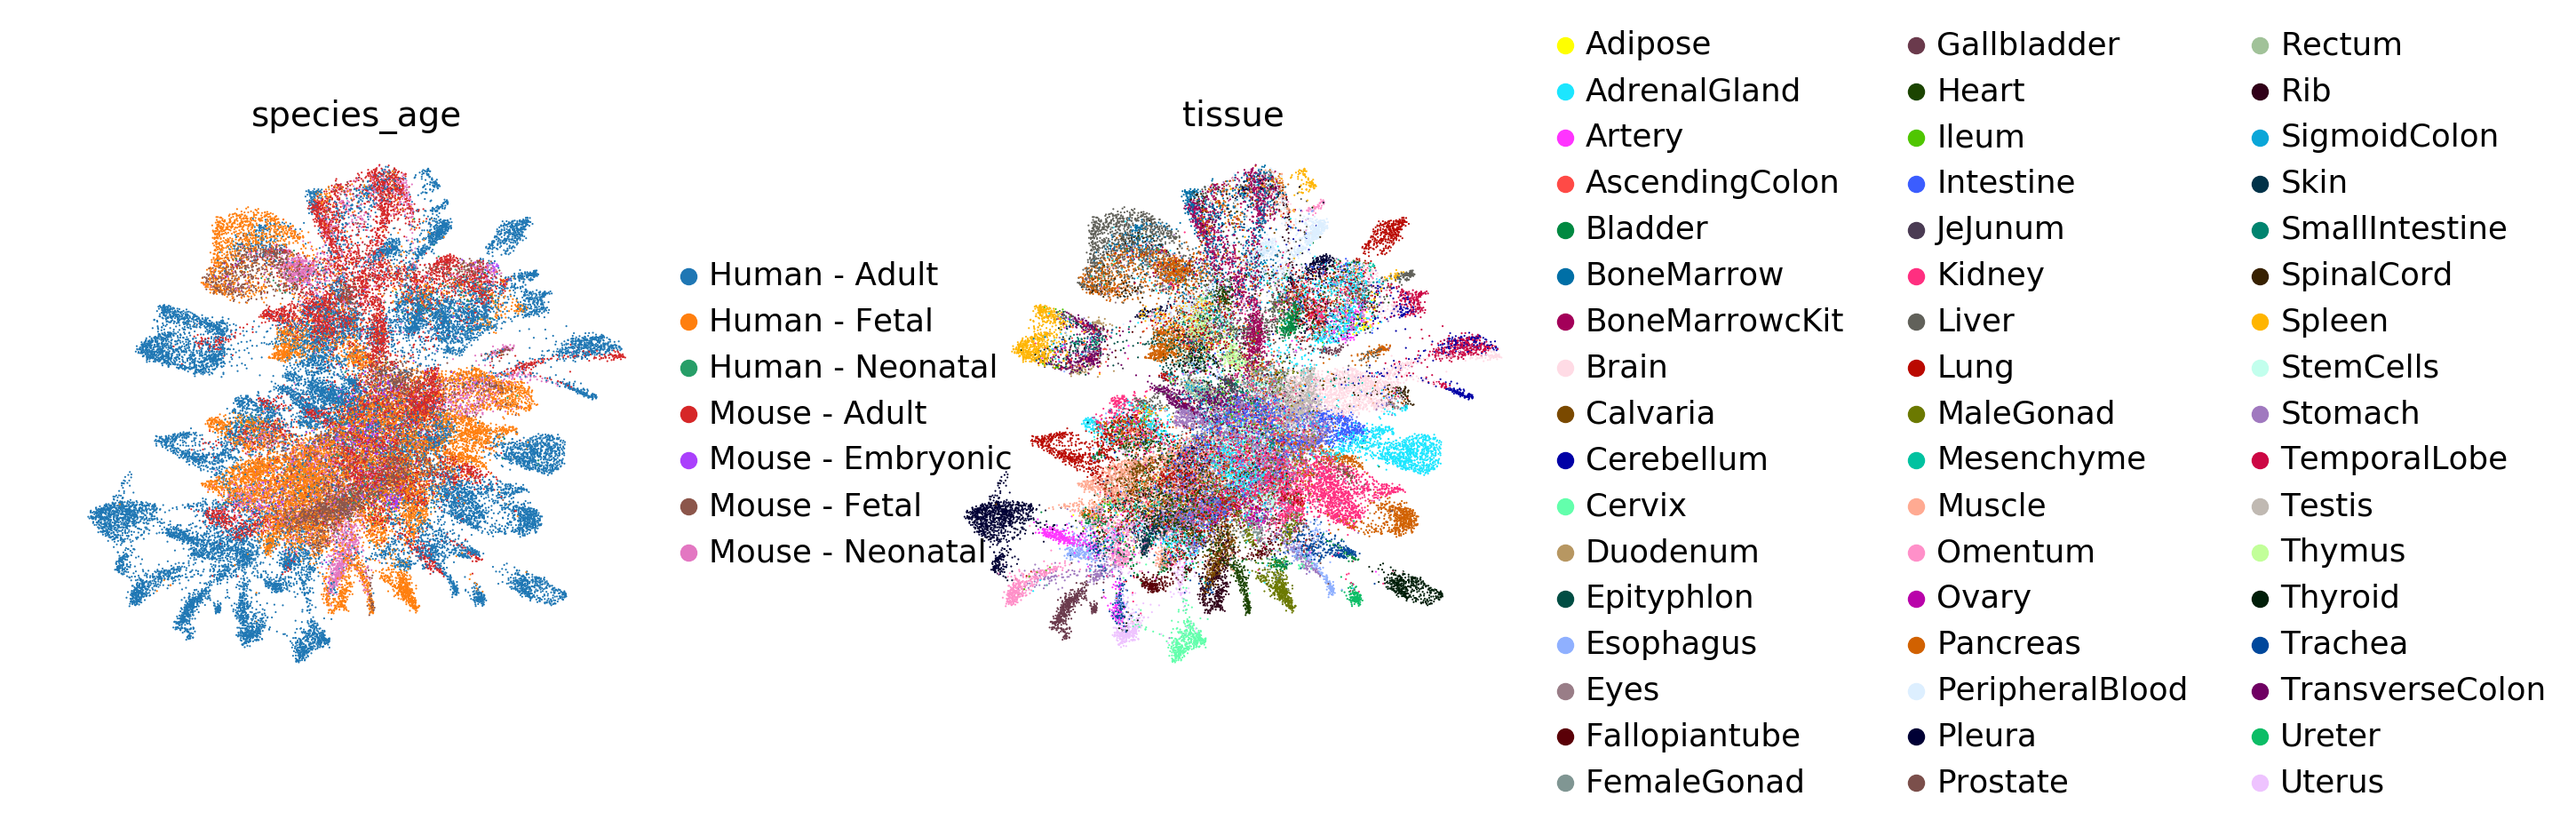

In [47]:
sc.pl.umap(latent_adata, color=['species_age', 'tissue'], wspace=0.35, frameon=False)

In [ ]:
latent_adata.write_h5ad(os.path.join(base_path, "latents/species_age/hcl+mca.h5ad"))

In [49]:
latent_adata.obs['spec_celltype'] = latent_adata.obs['celltype'].apply(lambda x: celltype_processor(x))

In [50]:
special_latent = latent_adata[latent_adata.obs['spec_celltype'].isin(special_cell_types)]

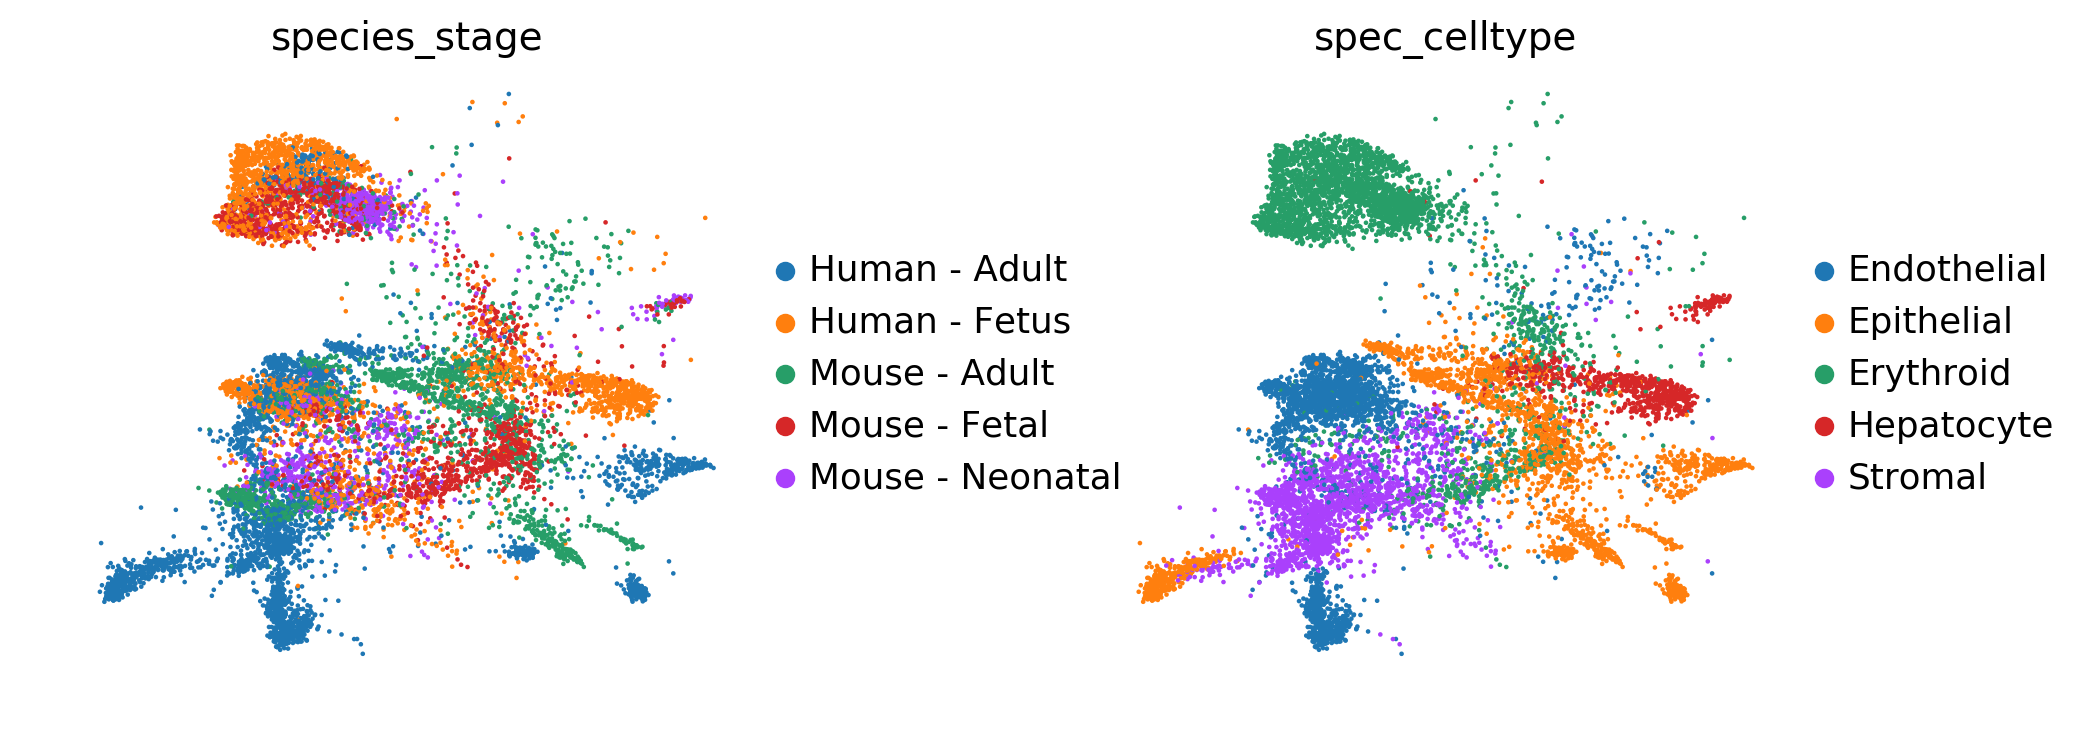

In [54]:
sc.pl.umap(special_latent, color=['species_stage', 'spec_celltype'], wspace=0.4, frameon=False)

In [78]:
latent_adata

AnnData object with n_obs × n_vars = 302778 × 20 
    obs: 'age', 'batch', 'cellnames', 'celltype', 'cluster', 'donor', 'sample', 'species', 'species_age', 'species_stage', 'species_tissue', 'stage', 'tissue', 'tissue_refined'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'